# Analyzing Financial Time Series with BigQuery and Cloud Datalab (Tutorial)

This solution illustrates the power and utility of [BigQuery](https://cloud.google.com/bigquery/) and [Cloud Datalab](https://cloud.google.com/datalab/) as tools for quantitative analysis. The solution is divided into two parts. [The first part of the solution](https://cloud.google.com/solutions/time-series/bigquery-financial-forex) includes an introduction and helps you get set up. The second part (this notebook) contains the code and steps to follow.

**Note:** This tutorial is a Jupyter notebook. The notebook is a sequence of cells, where each cell is a block of input text that is evaluated to produce results. Make sure that you run the code cells in this tutorial in sequence. Running the code cells in order establishes the proper configuration for subsequent code cells before they are executed.

## Objectives

* Load a dataset into BigQuery.
* Use BigQuery and Cloud Datalab to perform various financial time series queries
* Visualize the results of the queries in Cloud Datalab.

## Initial Setup

Import the libraries that you need to work with time-related functions and with BigQuery:

In [62]:
import time
import google.datalab.bigquery as bq

This tutorial uses the Cloud Datalab [integration with BigQuery](https://github.com/googledatalab/pydatalab). For additional information about the libraries, refer to the [API documentation](https://github.com/googledatalab/pydatalab/tree/master/google/datalab/bigquery).

## Loading the sample data

This tutorial uses foreign exchange (FX) spot-market data, which represents international currency exchange rate quotes over time. This data is a record of the prices that brokers offer for currency trades that happen when people travel, when large financial institutions move funds between countries or regions, or when speculators trade currency for profit. FX data uses the following comma-separated format:

```
venue, from-currency/to-currency, timestamp, bid-price, ask-price
```

All quotes in the sample dataset are for exchanges between the British pound sterling (GBP) as the base (from) currency and the US dollar (USD) as the quote (to) currency. Timestamps are expressed in Greenwich Mean Time (GMT). The last three digits are always zero, so the time series resolution is one millisecond. The bid price represents what buyers offered to pay for one unit of the base currency, and the ask price represents the price that sellers asked for it.

### Create a new dataset in BigQuery

1\. Create a new dataset in BigQuery:

In [ ]:
bq.Dataset('timeseries').create()

You can execute the code cell multiple times. If the dataset does not exist, running the code cell creates it. If a dataset already exists, running the code cell has no effect.

2\. Define a schema for the data and load the data from two CSV files by running the following code cell. The first file contains data for January 2014, and the second file contains data for February 2014. Loading these datasets can take some time.

In [ ]:
# A schema is defined as a list of dictionaries, 
# each entry in the list defining one element of the schema.
# For more details see https://github.com/googledatalab/pydatalab/blob/master/datalab/bigquery/_schema.py
schema = [
  {'name': 'venue', 'type': 'STRING', 'mode': 'REQUIRED'},
  {'name': 'currencies', 'type': 'STRING', 'mode': 'REQUIRED'},
  {'name': 'time_stamp', 'type': 'TIMESTAMP', 'mode': 'REQUIRED'},
  {'name': 'bid', 'type': 'FLOAT', 'mode': 'REQUIRED'},
  {'name': 'ask', 'type': 'FLOAT', 'mode': 'REQUIRED'}
]

bq.Table('timeseries.gbpusd_0114').create(
  schema = schema, overwrite = True).load(
  'gs://solutions-public-assets/time-series-master/GBPUSD_2014_01.csv')

bq.Table('timeseries.gbpusd_0214').create(
  schema = schema, overwrite = True).load(
  'gs://solutions-public-assets/time-series-master/GBPUSD_2014_02.csv')

3\. View the table schema for one of the tables that you just created by running the following cell:

In [ ]:
bq.Table('timeseries.gbpusd_0114').schema

## Query for January quotes

Start with some simple queries to see what the FX quote data looks like. 

1\. Use Cloud Datalab [bq cell magic](http://googledatalab.github.io/pydatalab/google.datalab%20Commands.html) to run the following query. The table allows you to page back and forth through the results with the left and right arrows at the bottom.

In [ ]:
%%bq query
SELECT
 venue,
 currencies,
 time_stamp,
 bid,
 ask
FROM
 timeseries.gbpusd_0114
ORDER BY
 time_stamp ASC
LIMIT
  1000

You can also use bq cell magic to name the query. Named queries allow you to reference previous SQL queries within Python code cells.

2\. Define a query called `quotes_for_january`:

In [3]:
%%bq query --name quotes_for_january
SELECT
 venue,
 currencies,
 time_stamp,
 bid,
 ask
FROM
 timeseries.gbpusd_0114
ORDER BY
 time_stamp ASC
LIMIT
  1000

A named query is a Python [`Query` object](http://googledatalab.github.io/pydatalab/google.datalab.bigquery.html#google.datalab.bigquery.Query) from the `google.datalab.bigquery` API.

3\. Run the following Python code cell to call the query's execute method:

In [ ]:
january = quotes_for_january.execute(output_options=bq.QueryOutput.dataframe()).result().set_index('time_stamp')
january.head(10)

The results of the query are converted into a Pandas DataFrame. [Pandas](https://pandas.pydata.org/pandas-docs/stable/index.html) is a Python package that was designed for data analysis. Pandas offers a breadth of functionality through its DataFrame data structure; for example, it can slice a DataFrame for a single minute of data. You can use BigQuery to process large datasets quickly, and then use Pandas, [NumPy](http://www.numpy.org/), or plain Python for refined manipulation in Cloud Datalab.

The column `time_stamp` is set as the index of the DataFrame. You can then use Python square brackets to retrieve data from the DataFrame, using a range of timestamps as the index.

4\. Run the following code cell to see the FX quotes for the first two seconds of January 1, from the DataFrame. 

In [ ]:
january['2014-01-01 00:01':'2014-01-01 00:02']

## View FX bids for a specific interval

You can modify the query to restrict the results to a specific interval. 

1\. Create a query to return a 30-minute period on January 1:

In [21]:
%%bq query --name bids_within_timeframe
SELECT
  time_stamp,
  bid
FROM
  timeseries.gbpusd_0114
WHERE
  time_stamp BETWEEN TIMESTAMP("2014-01-01 00:00:00.000")
  AND TIMESTAMP("2014-01-01 00:29:59.999")
ORDER BY
  time_stamp ASC

2\. Execute the query, and convert it to a Pandas DataFrame:

In [ ]:
bids_within_timeframe_results = bids_within_timeframe.execute(output_options=bq.QueryOutput.dataframe()).result()
bids_within_timeframe_results.head(10)

3\. Visualize these bids by using the Pandas `plot` method and the timestamp for the x-axis:

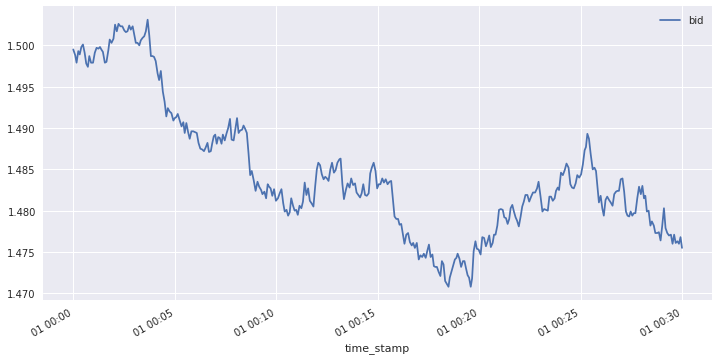

In [24]:
# A useful trick is to assign the return value from plot() to _ to avoid getting text printed before the chart
_ = bids_within_timeframe_results.set_index('time_stamp').plot(figsize=(12,6))

You can see that the US dollar trended lower against the pound for most of the first 20 minutes of the day, and then recovered for the next five minutes.

4\. Visualize this data with Google Charts [chart cell magic](http://googledatalab.github.io/pydatalab/google.datalab%20Commands.html):

In [25]:
%%chart annotation --fields time_stamp,bid --data bids_within_timeframe
height: 400
width: 800
numberFormats: '0.000'
displayZoomButtons: 'false'

The results appear in the same graph as the previous one, but Google Charts adds interactivity. You can zoom in and out of the time range by dragging the handles at the bottom corners of the graph, and you can see the value of individual bids from the curve. Experiment with more chart configuration options from [this list](https://developers.google.com/chart/interactive/docs/gallery/annotationchart#configuration-options).

Visualization in Pandas is useful for experimentation and iterative analysis. Visualization with Google Charts is useful for presentations and documents when image quality and interactivity are important.

## Combine tables

The data that you loaded into BigQuery was split between two CSV files and is in two tables. 

1\. Combine the data by embedding the following table query:

In [ ]:
%%bq query
SELECT
  MIN(time_stamp) AS min_ts,
  MAX(time_stamp)AS max_ts
FROM `timeseries.gbpusd_*`

In this query, the SQL statement combines all the tables with names that start with "gbpusd", which is true for both tables. The query returns the first and last timestamps that are in the data set.

2\. You can also combine tables using a `UNION` clause. For example, retrieve the ask prices around midnight GMT between January 31 and February 1:

In [107]:
%%bq query --name combine_tables
SELECT
    FORMAT_TIMESTAMP("%m-%d-%Y %r", time_stamp) AS time_stamp, ask 
  FROM
    timeseries.gbpusd_0114 
  WHERE
    time_stamp BETWEEN @ts_from AND @ts_to
UNION DISTINCT
SELECT 
    FORMAT_TIMESTAMP("%m-%d-%Y %r", time_stamp) AS time_stamp, ask 
  FROM
    timeseries.gbpusd_0214 
  WHERE
    time_stamp BETWEEN @ts_from AND @ts_to
ORDER BY
  time_stamp ASC

In this code cell, a `UNION DISTINCT` clause is used to combine the results from two separate queries. Each query selects the timestamp and ask price from their respective tables. The queries use two [parameters](https://cloud.google.com/bigquery/docs/parameterized-queries): `@ts_from` and `@ts_to` to request only rows within a timestamp range. The `ORDER` clause is applied to the result of the `UNION`.

The `FORMAT_TIMESTAMP` function serves two purposes. First, the timestamp must be in a format that can be sorted across both days. A format using the hour only would not work, because the sorted result would not include the second day. Second, it formats the chart label. While you could, for example, label the chart with the full UTC time, including microseconds, the additional time information isn't useful on the chart.

3\. Use bq cell magic to run the named query:

In [ ]:
%%bq execute --query combine_tables
parameters:
- name: ts_from
  type: TIMESTAMP
  value: '2014-01-31 23:30:00.000'
- name: ts_to
  type: TIMESTAMP
  value: '2014-02-01 00:29:59.999' 

This code cell runs the query, passing the parameter values for `@ts_from` and `@ts_to`. It is also possible to define the parameters in Python and pass them to the query.

4\. Run the following code cell to define a Python dictionary with the parameter names, types and values:

In [131]:
query_parameters = [
  {
    'name': 'ts_from',
    'parameterType': {'type': 'TIMESTAMP'},
    'parameterValue': {'value': '2014-01-31 23:30:00.000'}
  },
  {
    'name': 'ts_to',
    'parameterType': {'type': 'TIMESTAMP'},
    'parameterValue': {'value': '2014-02-01 00:29:59.999'}
  } 
]

5\. Run the following code cell to execute the query using the dictionary with the parameters and display the results in a graph:

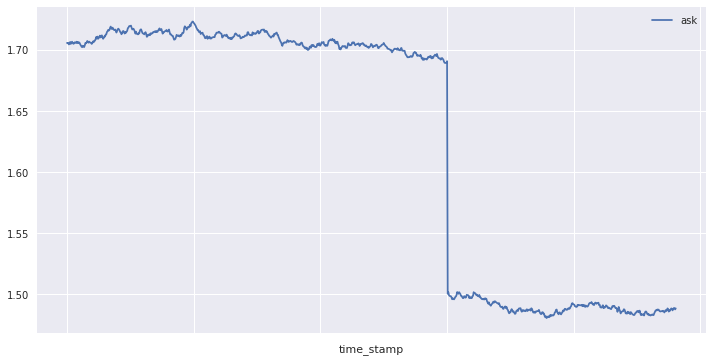

In [137]:
combine_tables_result = combine_tables.execute(output_options=bq.QueryOutput.dataframe(), query_params=query_parameters).result()
combine_tables_result.set_index('time_stamp').plot(figsize=(12,6))

The graph shows a sharp discontinuity in the ask price across the boundary between the two tables.

## Analyze data frequency

In financial markets, analyzing the way that quotes change over time can yield interesting information. You can run queries to get information about the number of FX quotes, called _ticks_, in a given period. A tick is not a consistent time unit, like the ticking of a clock; rather, a tick is a single quote.

1\. Create a query that returns the number of ticks per hour on January 16, 2014:

In [44]:
%%bq query --name hourly_frequencies
SELECT
  EXTRACT(HOUR FROM time_stamp) AS hour,
  COUNT(time_stamp) AS num_ticks
FROM
  timeseries.gbpusd_0114
WHERE
  time_stamp BETWEEN TIMESTAMP("2014-01-16 00:00:00.000")
  AND TIMESTAMP("2014-01-16 23:59:59.999")
GROUP BY
  hour
ORDER BY
  hour ASC;

2\. Run the query:

In [ ]:
frequencies = hourly_frequencies.execute(output_options=bq.QueryOutput.dataframe()).result().set_index('hour')
frequencies.head(10)

3\. View a bar chart of the results using Pandas:

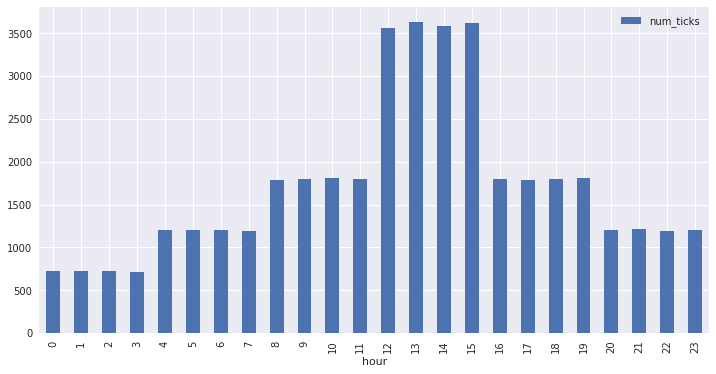

In [46]:
_ = frequencies.plot(kind='bar', figsize=(12,6))

4\. View a bar chart of the results using Google Charts:

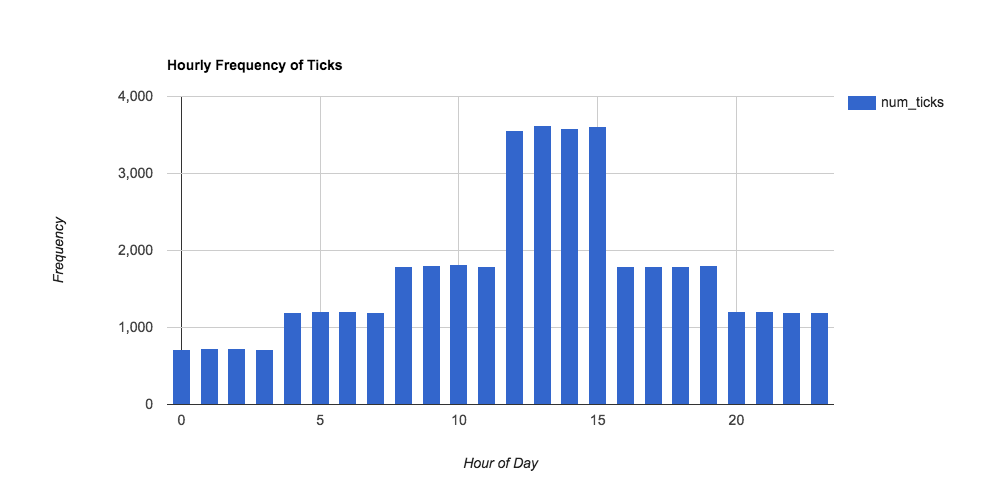

In [48]:
%%chart columns --fields hour,num_ticks --data hourly_frequencies
title: Hourly Frequency of Ticks
height: 500
width: 1000
hAxis:
  title: Hour of Day
vAxis:
  title: Frequency
legend: None

The chart shows that the most activity occurred between noon and 4 PM GMT on that day.

5\. Create a query that returns the daily average of ticks per hour for all of January 2014.

In [51]:
%%bq query --name average_frequencies
SELECT
  EXTRACT(HOUR FROM time_stamp) AS hour,
  COUNT(time_stamp)/COUNT(DISTINCT EXTRACT(DAY FROM time_stamp)) AS avg_ticks
FROM
  timeseries.gbpusd_0114
GROUP BY
  hour
ORDER BY
  hour ASC;

The query divides the total number of ticks by the number of trading days in the month and then groups them by hour.

6\. Run the following code cell to see the distribution of ticks:

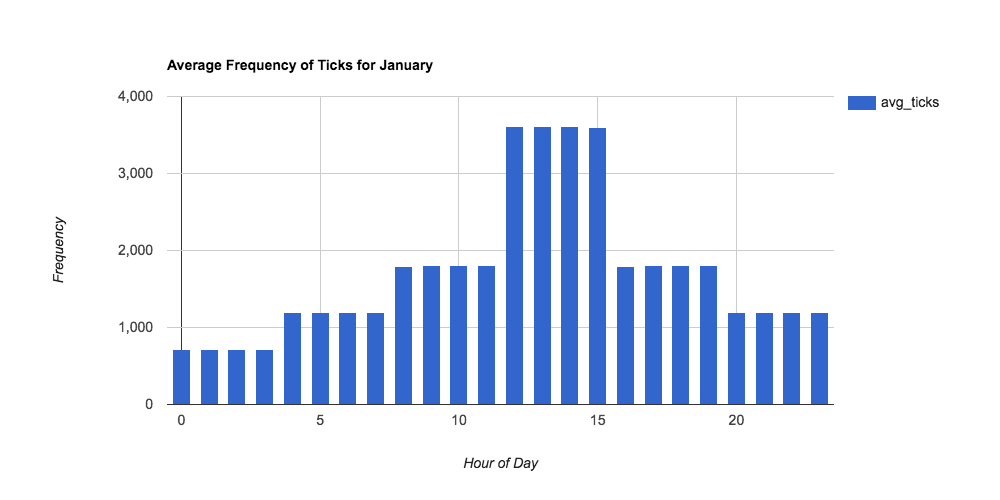

In [52]:
%%chart columns --fields hour,avg_ticks --data average_frequencies
title: Average Frequency of Ticks for January
height: 500
width: 1000
hAxis:
  title: Hour of Day
vAxis:
  title: Frequency
legend: None

## Compute a moving average

One fundamental technique for financial time-series analysis is the _simple moving average_ (SMA). You can use BigQuery to compute an SMA of the FX data.

1\. Create a query that retrieves a time series for the 60-second SMA of bid prices over three hours on the morning of January 16.  Use the [bq cell magic](http://googledatalab.github.io/pydatalab/google.datalab%20Commands.html) to name the query.

In [2]:
%%bq query --name simple_moving_average
SELECT
 TIME(time_stamp) AS bid_time,
 AVG (bid) OVER (ORDER BY sec_since_nine RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING) AS avg_bid
FROM (
  SELECT
    bid,
    time_stamp,
    TIMESTAMP_DIFF(time_stamp, TIMESTAMP("2014-01-16 09:00:00.000"), SECOND) AS sec_since_nine
  FROM
    timeseries.gbpusd_0114
  WHERE
    (time_stamp BETWEEN TIMESTAMP("2014-01-16 09:00:00.000") AND TIMESTAMP("2014-01-16 11:59:59.999"))
)

This query uses the [Standard SQL analytic functions](https://cloud.google.com/bigquery/docs/reference/standard-sql/analytic-function-concepts). Analytic functions compute aggregate values over a group of rows without involving expensive self-`JOIN`s. These groups of rows are called "windows," and are defined by the `OVER` clause. The `OVER` clause can contain three optional clauses: 

* `PARTITION BY`: divides input rows into sets with the same attribute value.
* `ORDER BY`: defines the ordering within a partition.
* Windowing expression: indicates a number of rows or a `RANGE` of values around the current row.

The query above uses the `TIMESTAMP_DIFF` function to extract the number of seconds elapsed since 9:00 AM. Then it uses the `ORDER BY` and `RANGE` clauses to build windows of rows between 30 seconds before and 30 seconds after the current row. Finally, it applies the `AVG` function to compute the average bid for that window. 
  
The query is nested because it is not possible to use field aliases, such as sec_since_nine, defined in the same `SELECT` as the analytic function. The inner query creates the column with the elapsed seconds and limits the results to the three hours between 9:00 AM and noon on January 16. The outer query then applies the analytic function over the results of the inner query.
  
This query is already simpler and more efficient than the equivalent moving average query built with self-`JOIN`s. However, there is an even simpler representation using the [WINDOW clause](https://cloud.google.com/bigquery/docs/reference/standard-sql/analytic-function-concepts#window-clause).
  
2\. Run the following code cell to redefine the simple moving average query: 


In [1]:
%%bq query --name simple_moving_average
SELECT
    TIME(time_stamp) AS bid_time,
    AVG (bid) OVER one_minute_window AS avg_bid
FROM
    timeseries.gbpusd_0114
WHERE
    (time_stamp BETWEEN TIMESTAMP("2014-01-16 09:00:00.000") AND TIMESTAMP("2014-01-16 11:59:59.999"))

WINDOW one_minute_window AS 
    (ORDER BY 
        TIMESTAMP_DIFF(time_stamp, TIMESTAMP("2014-01-16 09:00:00.000"), SECOND) 
    RANGE 
        BETWEEN 30 PRECEDING AND 30 FOLLOWING)

In this new version of the query, the `WINDOW` is defined after the `SELECT` statement, and the `OVER` clause references the window by its name. This technique avoids having to use the `sec_since_nine` alias, and in consequence having to use a nested query.

3\. Run the following code cell to generate a graph of the data:

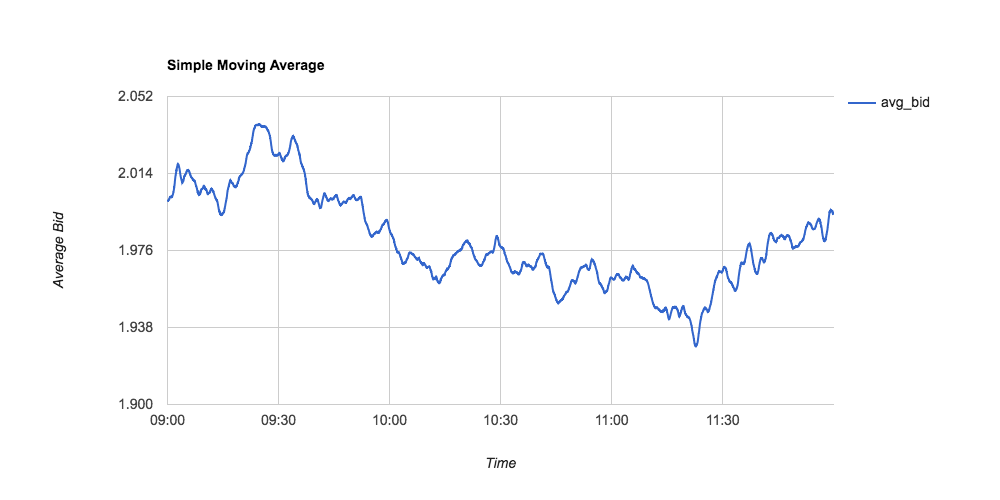

In [3]:
%%chart line --fields bid_time,avg_bid --data simple_moving_average
title: Simple Moving Average
height: 500
width: 1000
hAxis:
  title: Time
vAxis:
  title: Average Bid
legend: None

## Delete the test data

When you're done working with the test data, delete the dataset.

Uncomment the code in the following code cell and execute it.

In [ ]:
#bq.Dataset('timeseries').delete(delete_contents=True)